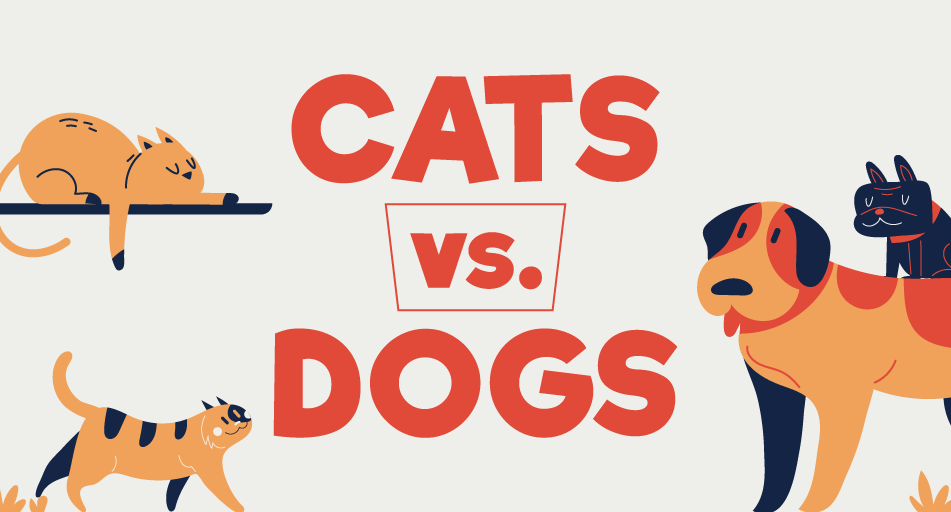

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import cv2 

# Models
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Data Splitting
from sklearn.model_selection import train_test_split

# Scailing
from sklearn.preprocessing import StandardScaler

Before we start with data visualization and modelling, we will create from the images we have the data frame that we will work with.<br>
<br>
To this end, we will define new functions that will help us read the images, resize them, change their colors to grayscale, and adjust them to the correct label of a dog or a cat.<br>
<br>
Using OpenCV library we'll read the images by their file path, resize them (to 64 by 64), and change their colors to grayscale.<br>
These operations will be performed in the following function.

In [4]:
def readImg_convert2gray_resize(file_path):
    img = cv2.imread(file_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (64,64))
    return resized_img

The next function will run on all the pictures of the cats and all the pictures of the dogs and use the previous function to arrange the pictures correctly in an array and add the corresponding label value to a separate array.

In [5]:
def img2array_addLabel(name, label):    
    numberOfImages=12500
    imgSize = 64*64
    X = np.ndarray((numberOfImages,imgSize), dtype=np.uint8)
    y = np.zeros((numberOfImages,1))
    folder = 'C:/Users/97254/Desktop/dogsVScats_train/train/'
    for i in range(numberOfImages):
        img = readImg_convert2gray_resize(folder + name + '.' + str(i) + '.jpg')
        X[i,:] = np.squeeze(img.reshape((imgSize,1)))
        y[i,0] = label
    return X,y

Once we have defined the new functions we can use them to load our data and turn it into a data frame that we can work with.

# Data Loading

### CATS

In [6]:
X1,y1 = img2array_addLabel('cat',0)
cat_df = pd.DataFrame(X1)
cat_df.shape

(12500, 4096)

In [7]:
cat_df['label'] = y1 # adding a column that expresses the label

### DOGS

In [8]:
X2,y2 = img2array_addLabel('dog',1)
dog_df = pd.DataFrame(X2)
dog_df.shape

(12500, 4096)

In [9]:
dog_df['label'] = y2 # adding a column that expresses the label

### MERGE DATA FRAMES

In [10]:
df = pd.concat([cat_df, dog_df])
df.shape

(25000, 4097)

As we can guess, our data frame is sorted by the label.<br>
Our next step is to mix all rows of our data frame before starting modelling.

In [11]:
df = df.sample(frac=1).reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,label
0,83,96,93,86,89,106,116,107,58,110,...,137,78,85,134,140,138,130,113,108,0.0
1,92,86,84,83,80,76,51,53,37,37,...,130,108,77,93,181,174,163,149,122,0.0
2,102,104,103,100,96,93,90,87,85,84,...,143,152,150,150,150,161,169,172,173,0.0
3,13,13,19,8,6,16,15,18,43,10,...,18,16,20,15,22,23,29,23,29,0.0
4,246,247,246,248,248,248,248,248,248,248,...,134,135,136,137,136,136,137,136,136,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,122,118,118,121,122,121,124,123,113,107,...,146,145,140,145,143,141,143,137,135,0.0
24996,67,73,98,102,100,118,90,114,69,78,...,89,40,32,22,44,39,129,41,38,1.0
24997,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1.0
24998,80,84,80,63,68,62,70,77,58,53,...,107,104,108,108,104,102,102,106,101,1.0


### Split into Final Test Set and Final Train Set

The data is adjusted only on the train set, so we have to split the data into train set and test set.<br>We will not touch the test set at all, while we will use the train set to decide which model will be the best.

In [12]:
FinalTest = df.iloc[:3570, :].reset_index(drop=True)
FinalTrain = df.iloc[3570:, :].reset_index(drop=True)

In [13]:
FinalTrain.shape

(21430, 4097)

In [14]:
FinalTest.shape

(3570, 4097)

We will check that the data is well divided between the test set and the train set.<br>
<br>
First we can see according to the next pie that we have the same amount of cats and dogs in our data frame.

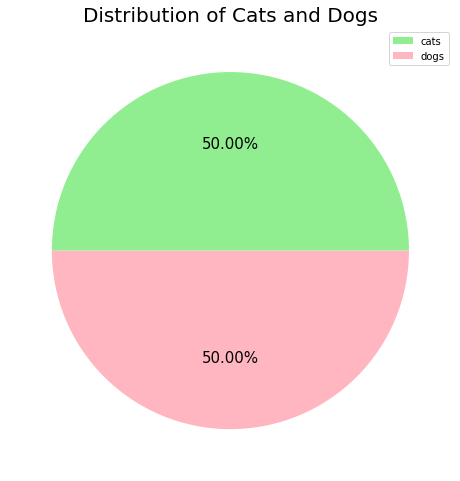

In [20]:
label = ['cats', 'dogs']

sorted_df = df.sort_values(by=['label'])
plt.subplots(figsize=(8, 9))
plt.pie(sorted_df['label'].value_counts(), colors = ['lightgreen', 'lightpink'], autopct = '%.2f%%' , textprops={"fontsize":15})
plt.title('Distribution of Cats and Dogs' , fontdict = {'fontsize' : 20})
plt.legend(label , loc=1)

plt.show()

Next, according to the two next pies we can see that also the final sets are well divided.

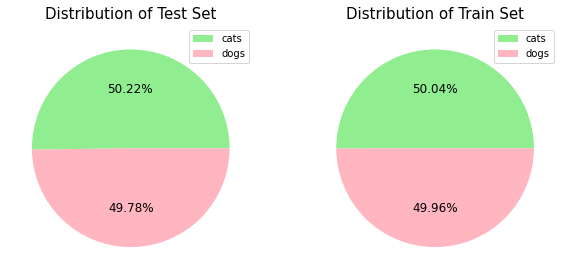

In [21]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sorted_test = FinalTest.sort_values(by=['label'])
plt.pie(sorted_test['label'].value_counts(), colors = ['lightgreen', 'lightpink'], autopct = '%.2f%%' , textprops={"fontsize":12})
plt.title('Distribution of Test Set' , fontdict = {'fontsize' : 15})
plt.legend(label , loc=1)

plt.subplot(2,2,2)
sorted_train = FinalTrain.sort_values(by=['label'])
plt.pie(sorted_train['label'].value_counts(), colors = ['lightgreen', 'lightpink'], autopct = '%.2f%%' , textprops={"fontsize":12})
plt.title('Distribution of Train Set' , fontdict = {'fontsize' : 15})
plt.legend(label , loc=1)

plt.show()

After we saw that the data is organized, we can split the final train set into another train and test sets that we can work with, untill we will find our best model.

# Visualization of Data

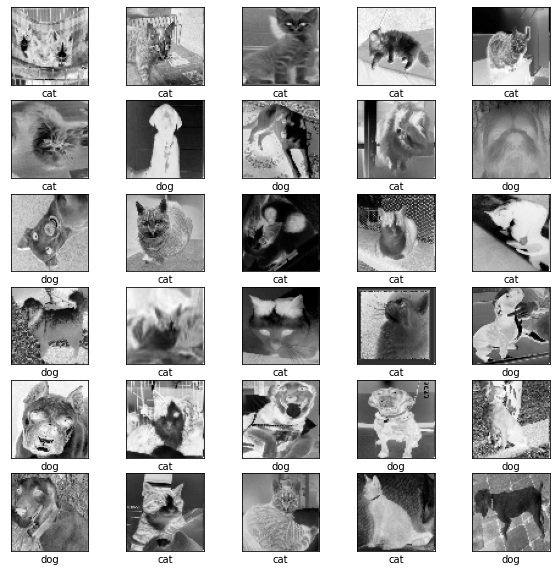

In [22]:
# Meaning of each label
label = ['cat', 'dog']

# Scailing by dividing all in 255
input_data = df.iloc[:,1:] / 255
target = df[['label']].iloc[:, :]
# Set the figure size
plt.figure(figsize=(10,10))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(input_data.iloc[i, :]).reshape(64,64), cmap=plt.cm.binary)
    plt.xlabel(label[int(target.label.iloc[i])])

In [23]:
X = FinalTrain.drop('label', axis=1)
y = FinalTrain.label


# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=4)

In [25]:
X_train.shape

(17786, 4096)

In [27]:
X_test.shape

(3644, 4096)

# PCA

During the semester we learned about the importance of dimensionality reduction.<br> We will now try to see this importance and then we will use dimensionality reduction.<br>
<br>
Let's see how dimensionality reductiot is expressed in the images themselves.

In [28]:
pca = PCA(n_components=16)
X_reduced = pca.fit_transform(X_train)

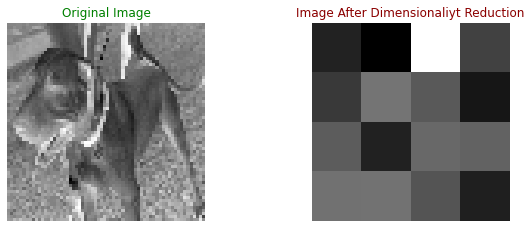

In [29]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(X_train.to_numpy()[2245].reshape(64,64) , cmap="gist_yarg")
plt.title("Original Image" , color="green")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(X_reduced[2245].reshape(4,4) , cmap="gist_yarg")
plt.title("Image After Dimensionaliyt Reduction" , color="darkred")
plt.axis("off")
plt.show()

We will try to find the lowest value for which we can identify as many labels as we want.

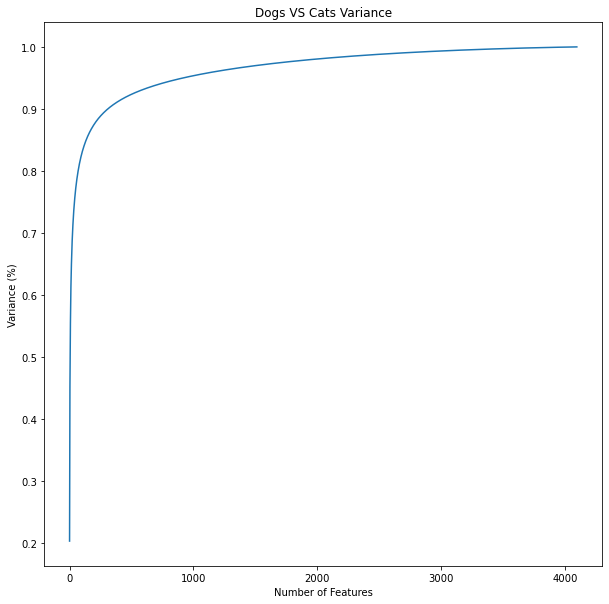

In [30]:
# fit the PCA with the training data
pca = PCA().fit(X_train)

# Plot the cumulative sum of eigenvalues
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.ylabel('Variance (%)') #for each component
plt.title('Dogs VS Cats Variance')
plt.show()

We'll check only untill 250 because the accuracy is high enough for us.<br>
We'll use PIPLINE to evaluate the score of each model.<br>
Before starting we'll try to find the amount of features by using Random Forest Classifier.

In [31]:
def PiplineScore(model , nComponents):
    pipeline_model = Pipeline([('scaler', StandardScaler()),
                               ('pca' , PCA(n_components=nComponents)),
                               ('model' , model())])

    pipeline_model.fit(X_train, y_train)
    print(model() , "Accuracy :  " , pipeline_model.score(X_test, y_test))
    return pipeline_model.score(X_test, y_test)

In [32]:
k_range = list(range(1,270,20))
scores = []
for k in k_range:
    score = PiplineScore(RandomForestClassifier , k)
    scores.append(score)

RandomForestClassifier() Accuracy :   0.49533479692645443
RandomForestClassifier() Accuracy :   0.6223929747530187
RandomForestClassifier() Accuracy :   0.6314489571899012
RandomForestClassifier() Accuracy :   0.6215697036223929
RandomForestClassifier() Accuracy :   0.6119648737650933
RandomForestClassifier() Accuracy :   0.6100439077936334
RandomForestClassifier() Accuracy :   0.6193743139407245
RandomForestClassifier() Accuracy :   0.615257958287596
RandomForestClassifier() Accuracy :   0.6034577387486278
RandomForestClassifier() Accuracy :   0.6031833150384193
RandomForestClassifier() Accuracy :   0.6094950603732162
RandomForestClassifier() Accuracy :   0.6053787047200878
RandomForestClassifier() Accuracy :   0.5971459934138309
RandomForestClassifier() Accuracy :   0.6089462129527992


Text(0.5, 1.0, 'Random Forest Classifier')

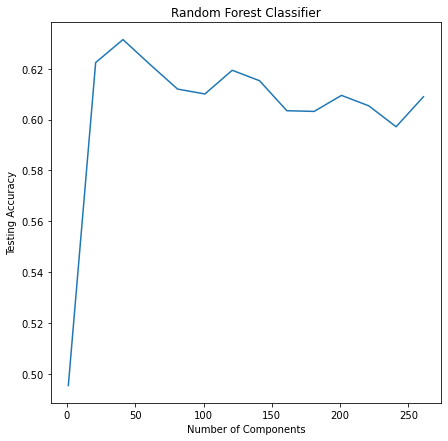

In [33]:
plt.figure(figsize=(7,7))
plt.plot(k_range, scores)
plt.xlabel('Number of Components')
plt.ylabel('Testing Accuracy')
plt.title('Random Forest Classifier')

We can understand that between 0 to 25 is the most change in accuracy.<br>
We'll look for the most lowest number of components that still gives us an acceptable accuracy.

In [34]:
k_range = list(range(1,25))
scores_0_25 = []
for k in k_range:
    score = PiplineScore(RandomForestClassifier , k)
    scores_0_25.append(score)

RandomForestClassifier() Accuracy :   0.495609220636663
RandomForestClassifier() Accuracy :   0.535675082327113
RandomForestClassifier() Accuracy :   0.54198682766191
RandomForestClassifier() Accuracy :   0.557628979143798
RandomForestClassifier() Accuracy :   0.5806805708013172
RandomForestClassifier() Accuracy :   0.5826015367727772
RandomForestClassifier() Accuracy :   0.6012623490669594
RandomForestClassifier() Accuracy :   0.6094950603732162
RandomForestClassifier() Accuracy :   0.6026344676180022
RandomForestClassifier() Accuracy :   0.6105927552140505
RandomForestClassifier() Accuracy :   0.6094950603732162
RandomForestClassifier() Accuracy :   0.6155323819978046
RandomForestClassifier() Accuracy :   0.608397365532382
RandomForestClassifier() Accuracy :   0.6158068057080132
RandomForestClassifier() Accuracy :   0.6248627881448957
RandomForestClassifier() Accuracy :   0.6190998902305159
RandomForestClassifier() Accuracy :   0.6185510428100988
RandomForestClassifier() Accuracy :  

Text(0.5, 1.0, 'Random Forest Classifier')

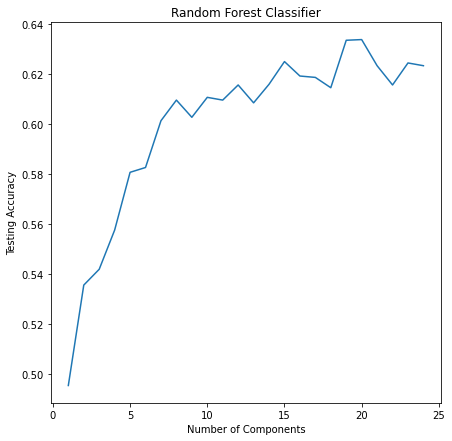

In [35]:
plt.figure(figsize=(7,7))
plt.plot(k_range, scores_0_25)
plt.xlabel('Number of Components')
plt.ylabel('Testing Accuracy')
plt.title('Random Forest Classifier')

As we can see 19 has an acceptable accuracy,<br>but we'll prefer 15 features in which the accuracy will be 62% than 19 features in which the accuracy is 63%.<br>
And so we will choose 15 as our n_components number.

In [37]:
def PiplineScore15(model):
    pipeline_model = Pipeline([('scaler', StandardScaler()),
                              ('pca' , PCA(n_components=15)),
                              ('model' , model)])

    pipeline_model.fit(X_train, y_train)
    print(model , "Accuracy :  " , pipeline_model.score(X_test, y_test))
    return pipeline_model.score(X_test, y_test)